In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import * 
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

import pandas as pd
import numpy as np
import os

fastai.version.__version__

'1.0.39'

In [3]:
# make sure CUDA is available and enabled
print('CUDA enabled:',torch.cuda.is_available()) 
print('CUDNN enabled:', torch.backends.cudnn.enabled)

CUDA enabled: True
CUDNN enabled: True


In [4]:
def recreate_directory(directory):
    !rm -R {directory} 2>nul
    !mkdir {directory}

# Dataset preprocessing

In [5]:
current_dir = os.getcwd()
input_path =f'{current_dir}/data'
train_dir = f"{input_path}/train"
train_labels = f"{input_path}/train.csv"
test_dir = f"{input_path}/test"
model_dir = f'{current_dir}/models'

## Train model

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0
arch = models.resnet50

In [7]:
df = pd.read_csv(train_labels)
df = df[df['Id']!='new_whale']
# df = df.sample(frac=0.25)
df = df.reset_index()

print(df.shape)
print(df.head())

(3924, 3)
   index          Image         Id
0  20411  cd9b982d9.jpg  w_5a49beb
1  17017  ab0694a88.jpg  w_60a54be
2  20791  d1525a470.jpg  w_88e4537
3  13587  88da7d67a.jpg  w_27a6304
4  23005  e7dcfaca8.jpg  w_96c6613


In [8]:
grouped_df = df.groupby('Id')
grouped_counted = grouped_df.count().sort_values(by=['Image'], ascending=False)
grouped_counted = grouped_counted[(grouped_counted['Image']>5) & (grouped_counted['Image']<1000)]
print(len(grouped_counted))
print(grouped_counted.sum().Image, 'of', len(df))
print(grouped_counted.head())

72
654 of 3924
           index  Image
Id                     
w_700ebb4     22     22
w_23a388d     19     19
w_564a34b     18     18
w_0369a5c     17     17
w_3de579a     17     17


In [9]:
valid_pct = 0.2

valid_filenames = pd.DataFrame(columns=df.columns)

for name, group in enumerate(grouped_df):
    sub_df = group[1]
#     if group[0] != 'new_whale' and (len(sub_df)>5):
    sample = sub_df.sample(frac=valid_pct)
    valid_filenames = valid_filenames.append(sample, ignore_index=True)

In [10]:
valid_filenames.drop(labels=['index'], axis=1, inplace=True, errors='ignore')

print(valid_filenames.shape)
print(valid_filenames.head())

(377, 2)
           Image         Id
0  b9aefbbc8.jpg  w_003bae6
1  8b279f035.jpg  w_007fefa
2  11116ae07.jpg  w_0135f5f
3  b9d2462fd.jpg  w_01cbbbd
4  12093d2aa.jpg  w_022b708


In [11]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [12]:
valid_files = ItemList.from_df(df=valid_filenames, path=train_dir, cols=['Image'])

In [13]:
test_files = ImageItemList.from_folder(test_dir)

In [14]:
# TODO label from df?
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
#         .no_split()
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

In [15]:
#data.show_batch(rows=3, fig_size=(SZ, SZ))

# Learning rate

In [16]:
#learn = create_cnn(data, arch, metrics=accuracy, model_dir=model_dir)

In [17]:
#learn.lr_find()

In [18]:
#learn.recorder.plot()

# Precompute

In [19]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir=model_dir, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy
1,8.143628,7.388798,0.037135
2,7.483804,6.814891,0.090186
3,6.879153,6.357988,0.122016
4,6.252852,5.949658,0.145889
5,5.633524,5.521170,0.193634


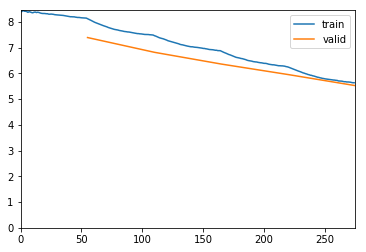

In [20]:
learn.fit(5, 1e-3)

In [22]:
# learn few epochs with unfreeze
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy
1,5.148407,5.509684,0.204244
2,4.884251,5.327419,0.220159
3,4.528939,5.095433,0.246684
4,4.141249,4.975384,0.251989
5,3.675547,4.875114,0.273210
6,3.222070,4.727314,0.297082
7,2.777034,4.656312,0.289125
8,2.357783,4.619339,0.283820
9,1.926522,4.471393,0.318302
10,1.587363,4.408428,0.328912


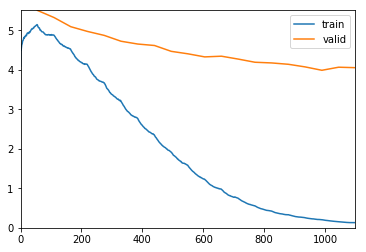

In [23]:
lr_rate = 5e-4
learn.fit(12, [lr_rate/100, lr_rate/10, lr_rate])

# Prediction & Summition - TODO

In [34]:
classes = learn.data.classes
print(len(classes))

2324


In [36]:
log_preds,y = learn.TTA()

In [37]:
preds = torch.cat((log_preds, torch.ones_like(log_preds[:, :1])), 1)

In [38]:
preds.shape

torch.Size([377, 2324])

In [39]:
submittion_df = pd.DataFrame(columns=["Image", "Id"])

In [40]:
for idx, val in enumerate(os.listdir(test_dir)):
    class_ids = preds[idx].argsort()[-5:]
    class_1 = classes[class_ids[0]]
    class_2 = classes[class_ids[1]]
    class_3 = classes[class_ids[2]]
    class_4 = classes[class_ids[3]]
    class_5 = classes[class_ids[4]]
    prediction_row = f'{class_1} {class_2} {class_3} {class_4} new_whale'
    submittion_df = submittion_df.append({'Image' : val.split(".")[0], 'Id': prediction_row}, ignore_index=True)

IndexError: index 377 is out of bounds for dimension 0 with size 377

In [31]:
print(submittion_df.shape)
submittion_df.head()

In [32]:
submittion_df.to_csv('submission-check1.csv', index=False)

In [33]:
print(submission.head())
print(submission.shape)